In [1]:
import matplotlib.pyplot as plt
from skimage import color, io, exposure
import cv2

In [2]:
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
from SinGAN.imresize import imresize
from SinGAN.imresize import imresize_to_shape
import SinGAN.functions as functions

In [3]:
in_video_path = "/home/vajira/simula/data/R_1004_11.02.03_1_HH.avi"

In [4]:
frame = io.imread("/home/vajira/DL/singan-sperm/Input/Paint/sperm_6_3ch_gray.png")
gray = color.rgb2gray(frame)
gray_3ch =  color.gray2rgb(gray) * 255


In [12]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

In [14]:
gray_3ch

array([[[102, 102, 102],
        [102, 102, 102],
        [102, 102, 102],
        ...,
        [108, 108, 108],
        [111, 111, 111],
        [113, 113, 113]],

       [[ 99,  99,  99],
        [ 99,  99,  99],
        [ 99,  99,  99],
        ...,
        [108, 108, 108],
        [112, 112, 112],
        [114, 114, 114]],

       [[ 99,  99,  99],
        [ 98,  98,  98],
        [ 98,  98,  98],
        ...,
        [107, 107, 107],
        [111, 111, 111],
        [115, 115, 115]],

       ...,

       [[113, 113, 113],
        [115, 115, 115],
        [119, 119, 119],
        ...,
        [123, 123, 123],
        [136, 136, 136],
        [143, 143, 143]],

       [[115, 115, 115],
        [118, 118, 118],
        [122, 122, 122],
        ...,
        [146, 146, 146],
        [147, 147, 147],
        [140, 140, 140]],

       [[116, 116, 116],
        [119, 119, 119],
        [124, 124, 124],
        ...,
        [150, 150, 150],
        [154, 154, 154],
        [140, 140, 140]]

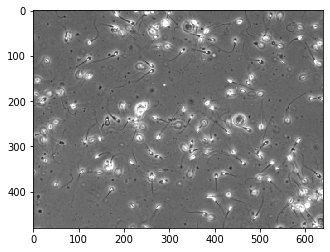

In [13]:
plt.imshow(gray_3ch)

In [25]:
gray_3ch

array([[[102., 102., 102.],
        [102., 102., 102.],
        [102., 102., 102.],
        ...,
        [108., 108., 108.],
        [111., 111., 111.],
        [113., 113., 113.]],

       [[ 99.,  99.,  99.],
        [ 99.,  99.,  99.],
        [ 99.,  99.,  99.],
        ...,
        [108., 108., 108.],
        [112., 112., 112.],
        [114., 114., 114.]],

       [[ 99.,  99.,  99.],
        [ 98.,  98.,  98.],
        [ 98.,  98.,  98.],
        ...,
        [107., 107., 107.],
        [111., 111., 111.],
        [115., 115., 115.]],

       ...,

       [[113., 113., 113.],
        [115., 115., 115.],
        [119., 119., 119.],
        ...,
        [123., 123., 123.],
        [136., 136., 136.],
        [143., 143., 143.]],

       [[115., 115., 115.],
        [118., 118., 118.],
        [122., 122., 122.],
        ...,
        [146., 146., 146.],
        [147., 147., 147.],
        [140., 140., 140.]],

       [[116., 116., 116.],
        [119., 119., 119.],
        [124., 1

In [4]:
parser = get_arguments()
parser.add_argument('--input_dir', help='input image dir', default='Input/Images')
parser.add_argument('--input_name', help='training image name', required=False, default="dot_mask_new_3ch.png") # added default by vajira
parser.add_argument('--ref_dir', help='input reference dir', default='Input/Paint')
parser.add_argument('--ref_name', help='reference image name', required=False, default="sperm_6_3ch_gray.png")
parser.add_argument('--paint_start_scale', help='paint injection scale', type=int, required=False, default=3) # added default by vajira
parser.add_argument('--quantization_flag', help='specify if to perform color quantization training', type=bool, default=False)
parser.add_argument('--mode', help='task to be done', default='paint2image')
opt = parser.parse_args("")

In [6]:
opt

Namespace(Dsteps=3, Gsteps=3, alpha=10, beta1=0.5, gamma=0.1, input_dir='Input/Images', input_name='dot_mask_new_3ch.png', ker_size=3, lambda_grad=0.1, lr_d=0.0005, lr_g=0.0005, manualSeed=None, max_size=250, min_nfc=32, min_size=25, mode='paint2image', nc_im=3, nc_z=3, netD='', netG='', nfc=32, niter=2000, noise_amp=0.1, not_cuda=0, num_layer=5, out='Output', padd_size=0, paint_start_scale=3, quantization_flag=False, ref_dir='Input/Paint', ref_name='sperm_6_3ch_gray.png', scale_factor=0.75, stride=1)

In [11]:
opt = functions.post_config(opt)
Gs = []
Zs = []
reals = []
NoiseAmp = []
dir2save = functions.generate_dir2save(opt)

Random Seed:  6676


array([[[102, 102, 102],
        [102, 102, 102],
        [102, 102, 102],
        ...,
        [108, 108, 108],
        [111, 111, 111],
        [113, 113, 113]],

       [[ 99,  99,  99],
        [ 99,  99,  99],
        [ 99,  99,  99],
        ...,
        [108, 108, 108],
        [112, 112, 112],
        [114, 114, 114]],

       [[ 99,  99,  99],
        [ 98,  98,  98],
        [ 98,  98,  98],
        ...,
        [107, 107, 107],
        [111, 111, 111],
        [115, 115, 115]],

       ...,

       [[113, 113, 113],
        [115, 115, 115],
        [119, 119, 119],
        ...,
        [123, 123, 123],
        [136, 136, 136],
        [143, 143, 143]],

       [[115, 115, 115],
        [118, 118, 118],
        [122, 122, 122],
        ...,
        [146, 146, 146],
        [147, 147, 147],
        [140, 140, 140]],

       [[116, 116, 116],
        [119, 119, 119],
        [124, 124, 124],
        ...,
        [150, 150, 150],
        [154, 154, 154],
        [140, 140, 140]]

X shape= (1562, 2090, 3)
x after imread=== (1562, 2090, 3)


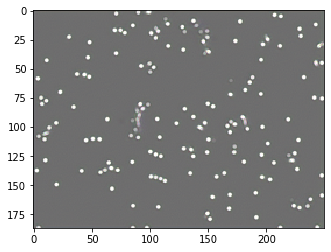

In [12]:
real = functions.read_image(opt)
real = functions.adjust_scales2image(real, opt)
Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt)

#ref = functions.read_image_dir('%s/%s' % (opt.ref_dir, opt.ref_name), opt)
ref = functions.np2torch(frame, opt)
ref = ref[:,0:3,:,:]
if ref.shape[3] != real.shape[3]:
    ref = imresize_to_shape(ref, [real.shape[2], real.shape[3]], opt)
    ref = ref[:, :, :real.shape[2], :real.shape[3]]

N = len(reals) - 1
n = opt.paint_start_scale
in_s = imresize(ref, pow(opt.scale_factor, (N - n + 1)), opt)
in_s = in_s[:, :, :reals[n - 1].shape[2], :reals[n - 1].shape[3]]
in_s = imresize(in_s, 1 / opt.scale_factor, opt)
in_s = in_s[:, :, :reals[n].shape[2], :reals[n].shape[3]]

out = SinGAN_generate(Gs[n:], Zs[n:], reals, NoiseAmp[n:], opt, in_s, n=n, num_samples=1)
np_out = functions.convert_image_np(out.detach())
plt.imshow(np_out, vmin=0, vmax=1)

X shape= (1562, 2090, 3)
x after imread=== (1562, 2090, 3)


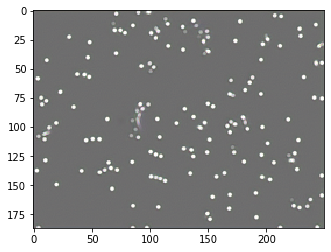

In [13]:
if dir2save is None:
        print('task does not exist')
    #elif (os.path.exists(dir2save)):
    #    print("output already exist")
else:
    try:
        os.makedirs(dir2save)
    except OSError:
        pass
    real = functions.read_image(opt)
    real = functions.adjust_scales2image(real, opt)
    Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt)
    if (opt.paint_start_scale < 1) | (opt.paint_start_scale > (len(Gs)-1)):
        print("injection scale should be between 1 and %d" % (len(Gs)-1))
    else:
        ref = functions.read_image_dir('%s/%s' % (opt.ref_dir, opt.ref_name), opt)
        if ref.shape[3] != real.shape[3]:
            ref = imresize_to_shape(ref, [real.shape[2], real.shape[3]], opt)
            ref = ref[:, :, :real.shape[2], :real.shape[3]]

        N = len(reals) - 1
        n = opt.paint_start_scale
        in_s = imresize(ref, pow(opt.scale_factor, (N - n + 1)), opt)
        in_s = in_s[:, :, :reals[n - 1].shape[2], :reals[n - 1].shape[3]]
        in_s = imresize(in_s, 1 / opt.scale_factor, opt)
        in_s = in_s[:, :, :reals[n].shape[2], :reals[n].shape[3]]
        '''
        if opt.quantization_flag:
            opt.mode = 'paint_train'
            dir2trained_model = functions.generate_dir2save(opt)
            # N = len(reals) - 1
            # n = opt.paint_start_scale
            real_s = imresize(real, pow(opt.scale_factor, (N - n)), opt)
            real_s = real_s[:, :, :reals[n].shape[2], :reals[n].shape[3]]
            real_quant, centers = functions.quant(real_s, opt.device)
            plt.imsave('%s/real_quant.png' % dir2save, functions.convert_image_np(real_quant), vmin=0, vmax=1)
            plt.imsave('%s/in_paint.png' % dir2save, functions.convert_image_np(in_s), vmin=0, vmax=1)
            in_s = functions.quant2centers(ref, centers)
            in_s = imresize(in_s, pow(opt.scale_factor, (N - n)), opt)
            # in_s = in_s[:, :, :reals[n - 1].shape[2], :reals[n - 1].shape[3]]
            # in_s = imresize(in_s, 1 / opt.scale_factor, opt)
            in_s = in_s[:, :, :reals[n].shape[2], :reals[n].shape[3]]
            plt.imsave('%s/in_paint_quant.png' % dir2save, functions.convert_image_np(in_s), vmin=0, vmax=1)
            if (os.path.exists(dir2trained_model)):
                # print('Trained model does not exist, training SinGAN for SR')
                Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt)
                opt.mode = 'paint2image'
            else:
                train_paint(opt, Gs, Zs, reals, NoiseAmp, centers, opt.paint_start_scale)
                opt.mode = 'paint2image'
        '''
        out = SinGAN_generate(Gs[n:], Zs[n:], reals, NoiseAmp[n:], opt, in_s, n=n, num_samples=1)
        np_out = functions.convert_image_np(out.detach())
        plt.imshow(np_out, vmin=0, vmax=1)
        #plt.imsave('%s/start_scale=%d.png' % (dir2save, opt.paint_start_scale), functions.convert_image_np(out.detach()), vmin=0, vmax=1)

In [10]:
def convert_single_frame_to_paint(frame, opt):
    opt = functions.post_config(opt)
    Gs = []
    Zs = []
    reals = []
    NoiseAmp = []
    dir2save = functions.generate_dir2save(opt)

    real = functions.read_image(opt)
    real = functions.adjust_scales2image(real, opt)
    Gs, Zs, reals, NoiseAmp = functions.load_trained_pyramid(opt)

    # Handle Ref::
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    ref = functions.np2torch(gray_3ch, opt)
    ref = ref[:,0:3,:,:]

    if ref.shape[3] != real.shape[3]:
        ref = imresize_to_shape(ref, [real.shape[2], real.shape[3]], opt)
        ref = ref[:, :, :real.shape[2], :real.shape[3]]

    N = len(reals) - 1
    n = opt.paint_start_scale
    in_s = imresize(ref, pow(opt.scale_factor, (N - n + 1)), opt)
    in_s = in_s[:, :, :reals[n - 1].shape[2], :reals[n - 1].shape[3]]
    in_s = imresize(in_s, 1 / opt.scale_factor, opt)
    in_s = in_s[:, :, :reals[n].shape[2], :reals[n].shape[3]]

    out = SinGAN_generate(Gs[n:], Zs[n:], reals, NoiseAmp[n:], opt, in_s, n=n, num_samples=1)
    np_out = functions.convert_image_np(out.detach())
    
    return np_out

    




In [7]:
def track_sperm(video_path, number_of_frames, out_video_path, track_scale=1):
    
   
    print("check pass")


In [8]:
in_s.shape

NameError: name 'in_s' is not defined

In [6]:
 cap = cv2.VideoCapture(in_video_path)

In [7]:
ret, frame = cap.read()

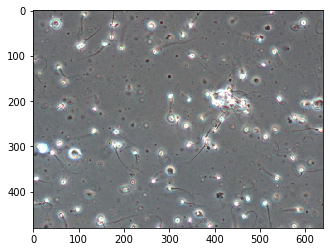

In [11]:
plt.imshow(frame)

In [12]:
frame.shape

(480, 640, 3)

In [7]:
frame = io.imread("/home/vajira/DL/singan-sperm/Input/Paint/sperm_6_3ch_gray.png")

In [8]:
gray = color.rgb2gray(frame)

In [9]:
gray_rgb = color.gray2rgb(gray)

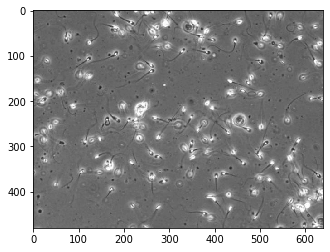

In [10]:
plt.imshow(gray_rgb)

Random Seed:  2863
X shape= (1562, 2090, 3)
x after imread=== (1562, 2090, 3)


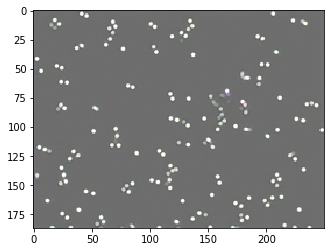

In [9]:
convert_single_frame(frame, opt)